In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import glob
import re
from matplotlib import colors
import collections
import matplotlib
import scipy.stats as stats
import math
import lmfit
import pandas as pd



from Geometry.Device import Device
import numpy as np
import matplotlib.pyplot as plt


#for event display
import sys
#path to event display directory - change with where your path is 
# sys.path.append("C:/Users/ms2609/Downloads/WCTE_event_display-main/")
import EventDisplay
import matplotlib.colors as colors
from platform import python_version
print(python_version())

3.11.5


## Load in data

Loads in the data, break in the loop to only load the first 10 files - can be tuned to look at specific files. Notebook will crash if too much data is loaded - loading only hits and not waveforms is an option to reduce memory

In [2]:
runNumber = 1731
#f'../data/2025_LaserBall/WCTE_offline_R{run}S*P*.root'
file_pattern = "../WCTE_offline_R"+str(runNumber)+"S0P*.root"
file_list = glob.glob(file_pattern)
print (file_list)

def extract_p_number(file_name):
    match = re.search(r'P(\d+)\.root$', file_name)  # Extract number after 'P'
    return int(match.group(1)) if match else float('inf')  # Convert to int, default high if no match

file_list = sorted(file_list, key=extract_p_number)
# print(file_list)

all_events_list = []

# Loop over files and load data
for ifile, file_path in enumerate(file_list):
    if ifile>9:
        break
    print(f"Loading: {file_path}")
    
    with uproot.open(file_path) as root_file:
        tree = root_file["WCTEReadoutWindows"]
        events = tree.arrays(library="ak")  # Load branches as awkward arrays
        all_events_list.append(events)  # Store in list

# Concatenate everything into a single awkward array
if all_events_list:
    all_events = ak.concatenate(all_events_list,axis=0)
    
print(f"Total events loaded: {len(all_events)}")

['..\\WCTE_offline_R1731S0P12.root']
Loading: ..\WCTE_offline_R1731S0P12.root
Total events loaded: 57221


In [3]:
hall = Device.open_file('wcte_bldg157.geo')
wcte = hall.wcds[0]

In [4]:
event = all_events[0]
mpmt_id = ak.to_numpy(ak.zeros_like(event['hit_mpmt_slot_ids']))
pmt_id = ak.to_numpy(ak.zeros_like(event['hit_pmt_position_ids']))

for event in all_events:
    #if occurs in first 10ms missing hits are expected
    # print("Is in first 10ms of 67ms?",event["window_time"]%67108864,event["window_time"]%67108864<1e7)
    mtemp_id = ak.to_numpy(event['hit_mpmt_slot_ids'])
    mpmt_id = np.concatenate((mpmt_id, mtemp_id))

    temp_id = ak.to_numpy(event['hit_pmt_position_ids'])
    pmt_id = np.concatenate((pmt_id, temp_id))
    


In [5]:
mpmt_unique = set(mpmt_id)
mpmt_unique = [item for item in mpmt_unique if item >= 0]
pmt_unique = set(pmt_id)   
pmt_unique = [item for item in pmt_unique if item >= 0]  

In [6]:
# Assume laser ball at top of detector along central line
# Should update to expected position for given run
laserball_pos = np.array([0.0,0.0,-80.0])

pmt_dist_map = np.zeros(shape=(len(mpmt_unique)*len(pmt_unique),3))

count = 0
# Use geometry tools to find location of all PMTs in detector and calculate travel times from the source
for mpmt in mpmt_unique:
    mpmt1 = wcte.mpmts[mpmt]
    if(mpmt < 0):
        continue
    for pmt in pmt_unique:
        if(pmt < 0):
            continue
        pmt1 = mpmt1.pmts[pmt]

        est_loc1 = np.array(pmt1.get_placement('est')['location'])
        distance = np.linalg.norm(est_loc1 - laserball_pos)
        # Convert distance to time in nanoseconds
        time = distance/225.0
        pmt_dist_map[count] = np.array([mpmt*19 + pmt, distance, time])
        count += 1

# Create data frame with pmt ID, distance from source and travel time of light
dist_df = pd.DataFrame(pmt_dist_map, columns=['pmt_id', 'distance','travel_time'])

[[0.00000000e+00 8.70568571e+02 3.86919365e+00]
 [1.00000000e+00 8.90636865e+02 3.95838607e+00]
 [2.00000000e+00 8.97731704e+02 3.98991868e+00]
 ...
 [2.01100000e+03 2.12990448e+03 9.46624215e+00]
 [2.01200000e+03 2.11866730e+03 9.41629910e+00]
 [2.01300000e+03 2.13950279e+03 9.50890130e+00]]


## Load event display of N events

In [7]:
# Select given number of events to look at in plots
event_no = 1
nEvents_to_show = 1000
event = all_events[event_no]
pmt_id = ak.to_numpy(ak.zeros_like(((event['hit_mpmt_slot_ids']*19)+event['hit_pmt_position_ids'])[event['hit_mpmt_card_ids']<120]))
#Make correct size array for cards in detector, filled with zeroes
data_to_plot = ak.to_numpy(ak.zeros_like(event['hit_pmt_charges'][event['hit_mpmt_card_ids']<120]))



In [8]:
print("Look at", nEvents_to_show, "events" )
counter = 0
for event in all_events:
    counter = counter + 1
    if counter > nEvents_to_show:
        break
    #if occurs in first 10ms missing hits are expected
    # print("Is in first 10ms of 67ms?",event["window_time"]%67108864,event["window_time"]%67108864<1e7)
    temp_id = ak.to_numpy(((event['hit_mpmt_slot_ids']*19)+event['hit_pmt_position_ids'])[(event['hit_mpmt_card_ids']<120) & (event['hit_pmt_times'] < 2500) & (event['hit_pmt_times'] > 500)])
    pmt_id = np.concatenate((pmt_id, temp_id))

    # Save the PMT hit time, assuming it is roughly in time and in a sensible readout card
    temp_data = ak.to_numpy(event['hit_pmt_times'][(event['hit_mpmt_card_ids']<120) & (event['hit_pmt_times'] < 2500) & (event['hit_pmt_times'] > 500)])
    data_to_plot = np.concatenate((data_to_plot, temp_data))

Look at 1000 events


In [9]:
# Check we have at least 10 hits in a PMT, removing PMTs without 10 hits
pmt_new = np.delete(pmt_id, np.where(data_to_plot < 10))
data_new = np.delete(data_to_plot, np.where(data_to_plot < 10))

# Subtract light travel time from hit time for PMTs with hits
for index in range(len(pmt_new)):
    pmt = pmt_new[index]
    data_new[index] -= (dist_df['travel_time'][(dist_df['pmt_id']==pmt)].item())
    

[1953.4949335   940.69898445 1190.23319136 ... 1564.13797439 1562.73718366
 1565.89221405]


(2014,)


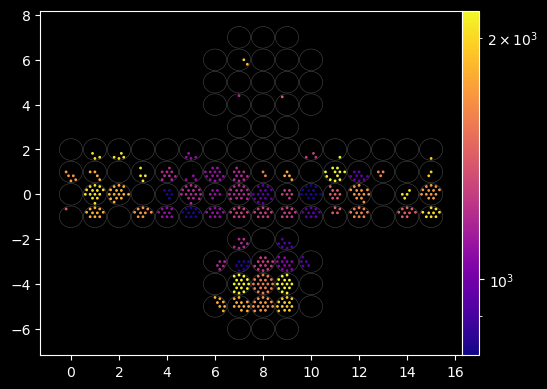

In [10]:
eventDisplay = EventDisplay.EventDisplay() 
eventDisplay.load_mPMT_positions('mPMT_2D_projection_angles.csv')

#process data has a sum_data option set to true by default, 
# if set to false it will only plot the smallest quantity for each PMT e.g. time 
# Sum and take average of hit times to see if thy are all aligned

ev_disp_data = eventDisplay.process_data(pmt_new,data_new,sum_data=True, average_data=True)

# eventDisplay.plotEventDisplay(ev_disp_data,color_norm=colors.Normalize(), style= "dark_background")
eventDisplay.plotEventDisplay(ev_disp_data,color_norm=colors.LogNorm(), style= "dark_background")
plt.show(block=False)
plt.style.use('default') 